In [1]:
import os
import librosa
import matplotlib
import scipy 
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter, savgol_filter
import soundfile as sf
from noisereduce import reduce_noise

import phast

import plotting
import utils

In [2]:
# PATH = "/home/nobeljpde1/abt/notebooks/tripletnoise.wav"
PATH = "/home/nobeljpde1/abt/data/din/903.wav"
NAME = os.path.basename(PATH).split(".")[0]

strategy = 'specres'
OUTPUT_NAME = f"{NAME}_reconstructed_{strategy}"

N_MELS = 64
N_FFT = 512
N_HOP = 32

MIN_FREQ = 450
MAX_FREQ = 5500
CS = True
scaling_factor = 1.4
n_trials = 20
apply_smoothing = False
BINSIZE = 18e-6 * 2
apply_premph = False
ref_db = 65.0

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

def pre_emphasis(signal: np.ndarray, factor: float = 0.97):
    return np.append(signal[0], signal[1:] - (factor * signal[:-1]))

def smooth(x, alpha = .995):
    s = x.copy()
    alpha1 = 1 - alpha
    for i in range(1, len(x)):
        s[i] = (s[i-1] * alpha) + (alpha1 * x[i])
    return s

if strategy == "specres":
    OUTPUT_NAME = f"{OUTPUT_NAME}_cs{CS}_preemph{apply_premph}"

In [3]:
if strategy == 'ace':
    tp = phast.load_cochlear()    
    (audio_signal, FS), pulse_train, neurogram = phast.ace_e2e(
        PATH,
        tp=tp,
        scaling_factor=scaling_factor,
        n_trials = n_trials,
    )
    
else:
    tp = phast.load_df120()
    if apply_smoothing:
        for i in range(tp.i_det.shape[1]):
            tp.i_det[:, i] = savgol_filter(tp.i_det[:, i], 51, 3)
    
    
    channel_freq = phast.scs.ab.defaults.virtual_channel_frequencies(tp.i_det.shape[1], MAX_FREQ + 100)
    power = 25
    w = (-tp.i_det / tp.i_det.sum(axis=1).reshape(-1, 1)) + (2 / len(channel_freq))
    w = np.power(w, power) / np.power(w, power).sum(axis=1).reshape(-1, 1)
    fiber_freq = w @ channel_freq      
            
    grouped = np.digitize(fiber_freq, MEL_SCALE, True)
    selected_fibers = []
    for fbin, nf in zip(*np.unique(grouped, return_counts=True)):
        selected_fibers.extend(
            sorted(np.random.choice(np.where(grouped == fbin)[0], min(10, nf), replace=False))
        )
    selected_fibers = np.array(selected_fibers)
    fiber_freq = fiber_freq[selected_fibers]
        
    audio_signal, audio_fs = phast.scs.ab.frontend.read_wav(PATH, stim_db=ref_db)
    audio_signal += np.random.normal(0, 1e-20, size=len(audio_signal)) # avoid log(0)
    
    if apply_premph:
        audio_signal = pre_emphasis(audio_signal[0]).reshape(1, -1)
    
    (audio_signal, FS), pulse_train, neurogram = phast.ab_e2e(
        audio_signal=audio_signal, 
        audio_fs=audio_fs,
        tp=tp,
        current_steering=CS, 
        scaling_factor=scaling_factor,
        n_trials = n_trials,
        accommodation_amplitude = 0.07,
        adaptation_amplitude = 7.142,
        accommodation_rate = 2,
        adaptation_rate = 19.996,
        ramp_duration=(audio_signal.size / audio_fs) * .05,
        selected_fibers=selected_fibers
    )
    audio_signal = audio_signal[0]

/tmp/ipykernel_2349095/1803681974.py:16: RuntimeWarning: divide by zero encountered in divide
  ratio = (spike_rate / pulse_rate)


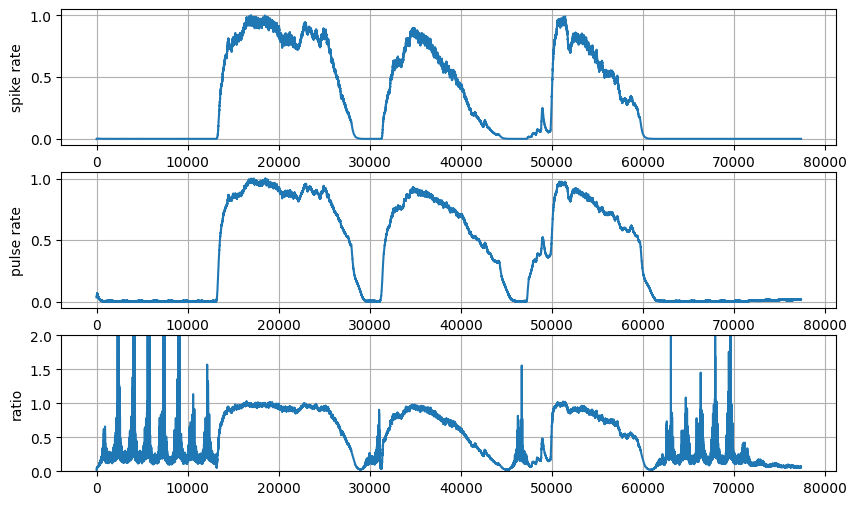

In [4]:
spike_rate = neurogram.data.sum(axis=0) / neurogram.data.shape[0]
pulse_rate = pulse_train.sum(axis=0) / pulse_train.shape[1]
mask = pulse_rate > 0
pulse_rate = np.interp(
    np.linspace(0, pulse_rate.shape[0], spike_rate.shape[0]), 
    np.arange(pulse_rate.shape[0])[mask], 
    pulse_rate[mask]
)
spike_rate = utils.min_max_scale(smooth(spike_rate), 0, 1)
pulse_rate = utils.min_max_scale(smooth(pulse_rate), 0, 1)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

ax1.plot(spike_rate)
ax2.plot(pulse_rate)
ratio = (spike_rate / pulse_rate)
ax3.plot(ratio)

ax1.set_ylabel("spike rate")
ax2.set_ylabel("pulse rate")
ax3.set_ylabel("ratio")
ax3.set_ylim(0, 2)

for ax in ax1, ax2, ax3:
    ax.grid()
    # ax.set_xlim(0, 1000)

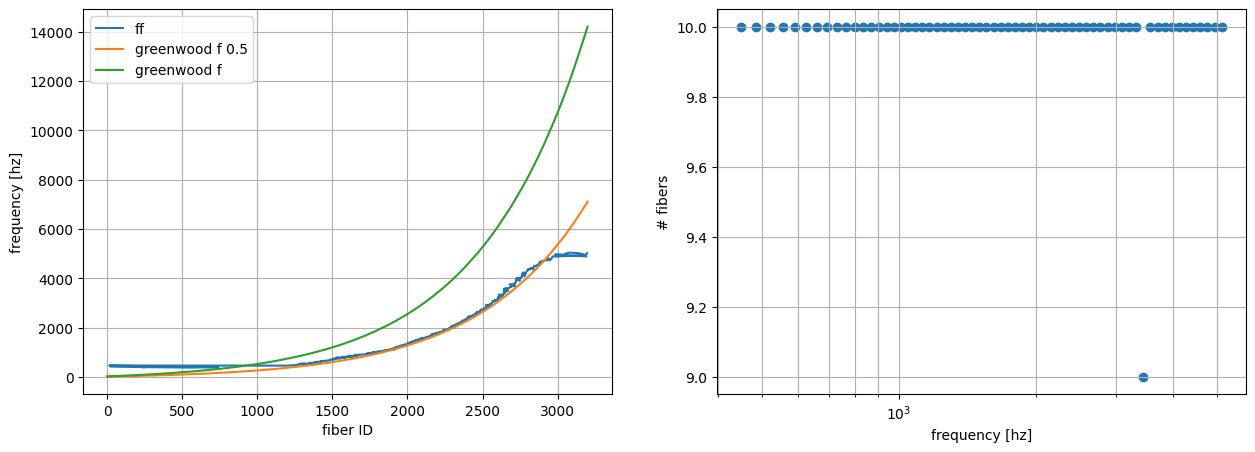

In [5]:
# # This is incorrect for ACE
# channel_freq = phast.scs.ab.defaults.virtual_channel_frequencies(tp.i_det.shape[1], MAX_FREQ + 500)

# power = 25
# w = (-tp.i_det / tp.i_det.sum(axis=1).reshape(-1, 1)) + (2 / len(channel_freq))
# w = np.power(w, power) / np.power(w, power).sum(axis=1).reshape(-1, 1)
# fiber_freq = w @ channel_freq


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(selected_fibers, fiber_freq, label='ff')
ax1.plot(tp.greenwood_f * .5, label="greenwood f 0.5")
ax1.plot(tp.greenwood_f, label="greenwood f")
ax1.legend()

ax1.set_ylabel("frequency [hz]")
ax1.set_xlabel("fiber ID")
ax1.grid()

# fiber_freq = (tp.greenwood_f).clip(0, MAX_FREQ - 1)
unique, counts = np.unique(np.digitize(fiber_freq, MEL_SCALE, True), return_counts=True)

ax2.scatter(MEL_SCALE[unique], counts)
ax2.set_ylabel("# fibers")
ax2.set_xlabel("frequency [hz]")
ax2.set_xscale("log")
ax2.grid(which="both")


In [6]:
# plotting.plot_pulse_train_stats(pulse_train, audio_signal, tp.electrode.m_level, tp.electrode.t_level, tp.electrode.pw, tp.i_det[:, ::9] if not CS else tp.i_det, FS, 21 if strategy == 'ace' else 15)

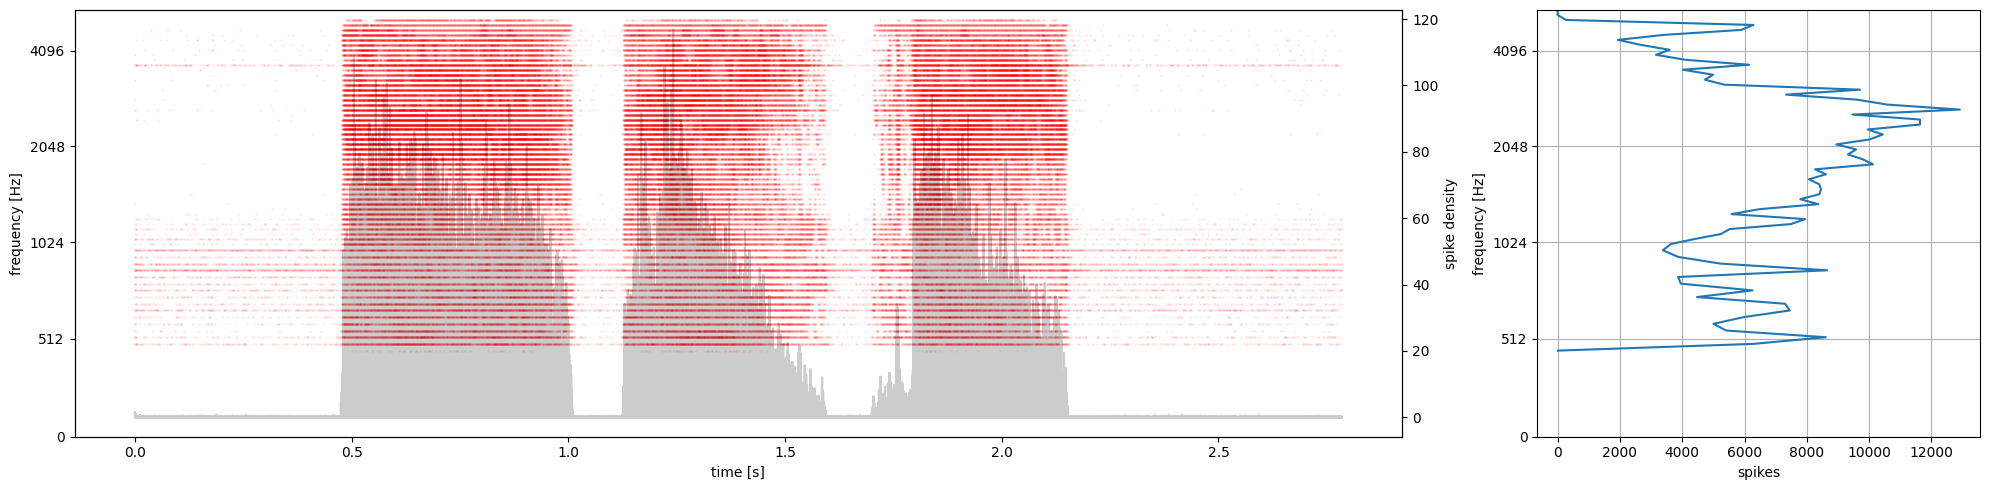

In [13]:
neurogram_freq_bin = utils.bin_over_y(neurogram.data, fiber_freq, MEL_SCALE, agg=np.mean)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for i in range(N_MELS):
    x = np.where(neurogram_freq_bin[i])[0]
    ax1.scatter(x * BINSIZE, MEL_SCALE[i] * np.ones(len(x)), color="red", alpha=.05, s=1)
    
density = neurogram_freq_bin.sum(axis=0)
ax3 = ax1.twinx()
ax3.plot(np.arange(len(density)) * BINSIZE, density, alpha=.2, color="black", zorder=-1)
ax3.set_ylabel("spike density")
      
ax2.plot(neurogram_freq_bin.sum(axis=1), MEL_SCALE)
ax2.grid()
ax2.set_xlabel("spikes")
plotting.frequency_ax(ax2)
plotting.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ)
# ax1.set_xlim(0, 1)
plt.tight_layout();  

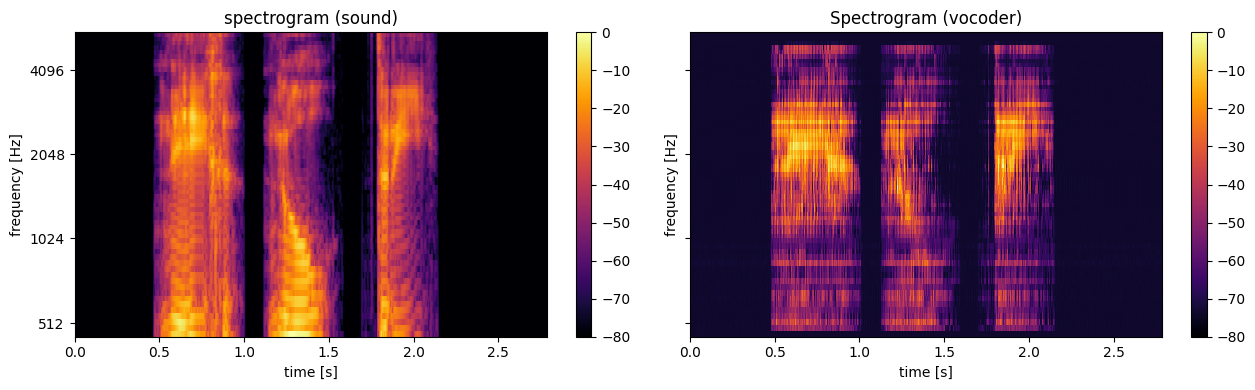

In [8]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

duration = len(audio_signal) * (1 / FS)
S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
S_db = librosa.power_to_db(S, ref=np.max)

ts = np.linspace(0, duration, len(S_db[0]))

plotting.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f, show_bands=False)
ax0.set_title("spectrogram (sound)")


n_s = int(np.ceil(audio_signal.shape[0] / N_HOP))
filtered_data = utils.apply_filter(neurogram_freq_bin, window_size=1, hop_length=1, clip_outliers=.999, resample_to=n_s, data_max=n_trials)

t = np.linspace(0, duration, len(filtered_data[0]))
plotting.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f, show_bands=False)
ax1.set_title("Spectrogram (vocoder)")

mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
plt.tight_layout()

In [9]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng, n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

In [10]:
def rmse(w):
    return np.sqrt(np.mean(w ** 2))

# ratio = rmse(audio_signal) / rmse(mel_inversed)
# mel_inversed *= ratio

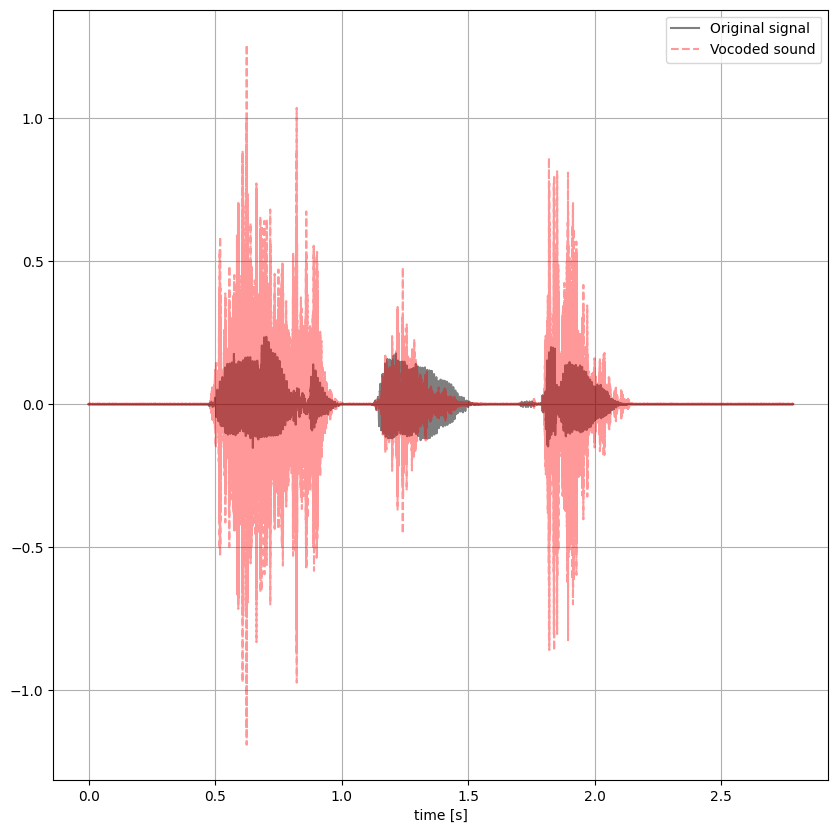

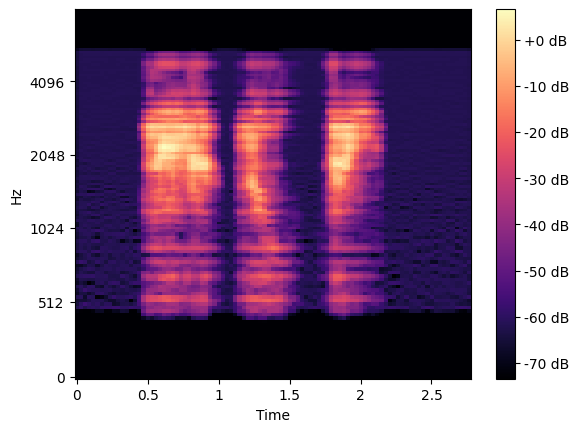

In [11]:
FS = int(FS)
t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.figure(figsize=(10, 10))
plt.plot(t_audio, audio_signal, label="Original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

# mel_inv_clipped = mel_inversed.clip(audio_signal.min(), audio_signal.max())
# ratio = rmse(audio_signal) / rmse(mel_inv_clipped)
# mel_inv_clipped *= ratio

# mel_inv_scaled = fix_scaling(mel_inversed, audio_signal.min(), audio_signal.max())


sound_eq = mel_inversed #/ smooth(np.abs(mel_inversed), .9)
# ratio = rmse(audio_signal) / rmse(sound_eq)
# sound_eq *= ratio

plt.plot(
    t_mel, 
    sound_eq,
    label="Vocoded sound", 
    color ="red", 
    linestyle="dashed", 
    alpha=.4
)

plt.grid()
plt.legend()
    
sf.write(
    f"output2/{OUTPUT_NAME}.wav", sound_eq, FS, 
    subtype='PCM_32'
)


fig, ax1 = plt.subplots()
S = librosa.feature.melspectrogram(y=sound_eq, sr=FS, fmax=8000)
S_dB = librosa.power_to_db(S,  ref=65.0)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=FS,
                         fmax=8000, ax=ax1)
fig.colorbar(img, ax=ax1, format='%+2.0f dB')
# sf.write(
#     f"output2/{OUTPUT_NAME}_scaled.wav", fix_scaling(mel_inversed, wav.min(), wav.max()), FS, 
#     subtype='PCM_32'
# )

In [12]:

def rmse(w):
    return np.sqrt(np.mean(w ** 2))


for f in os.listdir("output"):
    wav_in, sr = librosa.load(os.path.join("/home/nobeljpde1/abt/data/din", f), sr=None)
    wav, sr = librosa.load(os.path.join("output", f), sr=sr)
    # noise = np.random.normal(scale=0.4 * np.abs(wav), size=len(wav))
    noise = np.random.normal(scale=0.01, size=len(wav))
    wav = wav + noise
    ratio = rmse(wav_in) / rmse(wav)
    wav_scaled = ratio * wav
    
    sf.write(
        f"output2/output_noisy/{f}", wav_scaled, sr, 
        subtype='PCM_32'
    ) 
    print(f)
    # break
    
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharey=True, sharex=True)
ax1.plot(wav_in, label='original')
ax2.plot(wav, label='vocoded')
ax3.plot(wav_scaled, label='vocoded (scaled)')
ax1.set_title(rmse(wav_in))
ax2.set_title(rmse(wav))
ax3.set_title(rmse(wav_scaled))
for ax in ax1, ax2, ax3:
    ax.grid()
    ax.legend()

376.wav
026.wav
180.wav
410.wav
198.wav
501.wav
245.wav
912.wav
156.wav
379.wav
451.wav
230.wav
240.wav
892.wav
860.wav
632.wav
903.wav
584.wav
160.wav
394.wav
950.wav
046.wav
560.wav
321.wav
704.wav
792.wav
583.wav
750.wav
843.wav
109.wav
960.wav
931.wav
718.wav
102.wav
417.wav
732.wav
071.wav
967.wav
572.wav
167.wav
764.wav
162.wav
849.wav
157.wav
214.wav
985.wav
782.wav
063.wav
917.wav
657.wav
186.wav
862.wav
049.wav
652.wav
345.wav
025.wav


/tmp/ipykernel_2349095/1523945529.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  wav_in, sr = librosa.load(os.path.join("/home/nobeljpde1/abt/data/din", f), sr=None)
/home/nobeljpde1/abt/venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/home/nobeljpde1/abt/data/din/tripletnoise.wav'

In [ ]:
noise_or, sr = librosa.load("/home/nobeljpde1/abt/notebooks/tripletnoise.wav", sr=None)

# noise_re, sr = librosa.load("/home/nobeljpde1/abt/notebooks/tripletnoiseresampled.wav", sr=FS)

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)


# ax1.plot(wav_in)
# ax2.plot(wav_in)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))


fmax = 8000
ref = 65.0
ax1.set_title("Noise")
S = librosa.feature.melspectrogram(y=noise_or, sr=sr, fmax=fmax)
S_dB = librosa.power_to_db(S,  ref=ref)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=fmax, ax=ax1)
fig.colorbar(img, ax=ax1, format='%+2.0f dB')


ax2.set_title("Original")
S = librosa.feature.melspectrogram(y=wav_in, sr=sr, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=ref)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=fmax, ax=ax2)
fig.colorbar(img, ax=ax2, format='%+2.0f dB')


ax3.set_title("Vocoded")
Sv = librosa.feature.melspectrogram(y=wav_scaled, sr=sr, fmax=fmax)
S_dB = librosa.power_to_db(Sv,  ref=ref)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=fmax, ax=ax3)
fig.colorbar(img, ax=ax3, format='%+2.0f dB')



def fft_bandpass(x,  fs=1.0, low = 250, high = 2500):
    # padded_signal = np.pad(x, pad_width=(sr, sr), mode='constant')
    # filtered_padded_signal = bandpass_filter(padded_signal, sr, lowcut, highcut)
    # filtered_signal = filtered_padded_signal[sr:-sr]
    
    
    xf = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=1 / fs)
    xf[f < low] = 0
    xf[f > high] = 0
    return np.fft.irfft(xf, len(x))


def bandpass_filter(data, sr, lowcut, highcut, order=5):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    print(low, high)
    
    # padded_signal = np.pad(data, pad_width=(sr, sr), mode='constant')
    # filtered_padded_signal = bandpass_filter(padded_signal, sr, lowcut, highcut)
    # filtered_signal = filtered_padded_signal[sr:-sr]
    
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data


freqs = librosa.filters.mel_frequencies(N_MELS, fmin=0, fmax=fmax) 
freqs = freqs[Sv.mean(axis=1) > 1e-8]


ax4.set_title("Original filtered")
filt1 = fft_bandpass(wav_in, sr, 400, 5500)
fitl = bandpass_filter(filt1, sr, 750, 4000)

S = librosa.feature.melspectrogram(y=fitl, sr=sr, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=ref)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=fmax, ax=ax4)
fig.colorbar(img, ax=ax4, format='%+2.0f dB')
plt.tight_layout()


sf.write(
    f"output2/filt.wav", fitl, sr, 
    subtype='PCM_32'
) 


In [ ]:
for f in os.listdir("output"):
    wav_in, sr = librosa.load(os.path.join("/home/nobeljpde1/abt/data/din", f), sr=None)
    
    Sv = librosa.feature.melspectrogram(y=wav_in, sr=sr, n_mels=N_MELS, hop_length=N_HOP, fmin=MIN_FREQ, fmax=MAX_FREQ)
    mel_inversed = librosa.feature.inverse.mel_to_audio(Sv, n_fft=N_FFT, hop_length=N_HOP, sr=sr, fmin=MIN_FREQ, fmax=MAX_FREQ)
    
    mel_inversed = scipy.signal.resample(mel_inversed, wav_in.size)
    ratio = rmse(wav_in) / rmse(mel_inversed)
    mel_inversed *= ratio 
    
    sf.write(f"din2/mel_filt/{f}", mel_inversed, sr, subtype='PCM_32') 
    print(f, wav_in.size, mel_inversed.size)
    # break

In [ ]:
S = librosa.feature.melspectrogram(y=mel_inversed, sr=sr, n_mels=N_MELS, hop_length=N_HOP, fmin=MIN_FREQ, fmax=MAX_FREQ)
S_dB = librosa.power_to_db(S, ref=ref)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                        fmin=MIN_FREQ, fmax=MAX_FREQ)

In [43]:
wav_in, sr = librosa.load("/home/nobeljpde1/abt/notebooks/output2/967.wav", sr=None)

wav_in, sr = librosa.load("/home/nobeljpde1/abt/notebooks/tripletnoise_vocoded_eq.wav", sr=sr)


sf.write(
    "/home/nobeljpde1/abt/notebooks/tripletnoise_vocoded_eq.wav", wav_in, sr, 
    subtype='PCM_32'
)